## **Import Data**

In [76]:
import pandas as pd 

#import the data 
df = pd.read_csv('Data/heart_data.csv')

#quick view 
df.head()

HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
4       0.0           1.0     1.0  ...            1.0          0.0      2.0   

   MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  Income  
0      18.0      15.0       1.0  0.0   9.0        4.0     3.0  
1       0.0       0.0       0.0  0.0   7.0        6.0     1.0  
2      30.0      30.0       1.0  0.0   9.0        4.0     8.0  
3       0.0       0.0       0.0  0.0  11.0        3.0     6.0  
4       3.0       0.0       0.0  0.0  11.0        5.0     4.0  

[5 rows x 22 columns]

## **Preprocessor**

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

y = df['HeartDiseaseorAttack'] # remember, we want to predict who did or did not have a heart attack / disease 
X = df.loc[:, df.columns != 'HeartDiseaseorAttack'] # all other columns are features

# collect which encoder to use on each feature
# needs to be done manually
std_ftrs = ['BMI', 'MentHlth', 'PhysHlth', 'Income']
passthrough_ftrs = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker',
    'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
    'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education'
]

# collect all the encoders into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), std_ftrs),  # Standardize selected features
        ('passthrough', 'passthrough', passthrough_ftrs)  # Retain other features as-is
    ],
    remainder='drop'  # Drop any features not explicitly listed
)

prep = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess, later we will add other steps here

## **Random Forest**

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.pipeline import make_pipeline

# Custom F5 scorer
f5_scorer = make_scorer(fbeta_score, beta=5, average='binary')

# Random Forest-specific variables
rf_nr_states = 5  # Number of random states
rf_test_scores = np.zeros(rf_nr_states)  # Array to store test F5 scores
rf_final_models = []  # List to store the best models for each random state

# Hyperparameter grid
rf_param_grid = {
    'randomforestclassifier__max_depth': [3, 10, 21],  
    'randomforestclassifier__min_samples_split': [16, 32, 64, 128, 256], 
}

# Loop through different random states
for rf_state in range(rf_nr_states):
    print(f'Random State {rf_state + 1}')

    # First split to separate out the test set
    rf_X_other, rf_X_test, rf_y_other, rf_y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42 * rf_state
    )

    # K-Fold Cross-Validation
    kf = KFold(n_splits=5, random_state=42 * rf_state, shuffle=True)

    rf_clf = RandomForestClassifier(random_state=42 * rf_state, class_weight='balanced', n_jobs=-1)

    # Pipeline with preprocessing and classifier
    pipe = make_pipeline(preprocessor, rf_clf)

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        pipe,
        param_grid=rf_param_grid,
        scoring=f5_scorer,
        cv=kf,  
        n_jobs=-1,
        verbose=1
    )

    # Fit GridSearchCV on the training set
    grid_search.fit(rf_X_other, rf_y_other)

    # Get the best model and parameters
    best_rf_model = grid_search.best_estimator_
    rf_final_models.append(best_rf_model)
    print('Best Model Parameters:', grid_search.best_params_)
    print('Best Cross-Validated F5 Score:', grid_search.best_score_)

    # Evaluate on the test set (use raw rf_X_test here)
    rf_y_test_pred = best_rf_model.predict(rf_X_test)
    rf_test_scores[rf_state] = fbeta_score(rf_y_test, rf_y_test_pred, beta=5, average='binary')
    print(f'Test F5 Score for Random State {rf_state + 1}: {rf_test_scores[rf_state]:.4f}')

# Print average test F5 score and standard deviation
rf_average_test_f5 = np.mean(rf_test_scores)
rf_std_test_f5 = np.std(rf_test_scores)
print(f'\nAverage Test F5 Score: {rf_average_test_f5:.4f}')
print(f'Standard Deviation of Test F5 Score: {rf_std_test_f5:.4f}')


Random State 1
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Model Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 256}
Best Cross-Validated F5 Score: 0.7423320275459196
Test F5 Score for Random State 1: 0.7415
Random State 2
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Model Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 256}
Best Cross-Validated F5 Score: 0.7404031126783306
Test F5 Score for Random State 2: 0.7469
Random State 3
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Model Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 256}
Best Cross-Validated F5 Score: 0.7420645532722896
Test F5 Score for Random State 3: 0.7380
Random State 4
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Model Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 256}
Best Cross-Validated F5 Score: 0.745461

In [32]:
#Save RF File 
import pickle

# Save test scores to a .pkl file
with open('rf_test_scores.pkl', 'wb') as file:
    pickle.dump(rf_test_scores, file)

print("Test scores saved to rf_test_scores.pkl")

Test scores saved to rf_test_scores.pkl


## **Logistic Regression**

In [33]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.pipeline import make_pipeline

# Custom F5 scorer
f5_scorer = make_scorer(fbeta_score, beta=5, average='binary')

# Logistic Regression-specific variables
lr_nr_states = 5  # Number of random states
lr_test_scores = np.zeros(lr_nr_states)  # Array to store test F5 scores
lr_final_models = []  # List to store the best models for each random state

# Hyperparameter grid
lr_param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  # Regularization strengths
    'logisticregression__penalty': ['l1', 'l2'],       # Regularization type
    'logisticregression__solver': ['liblinear', 'saga']  # Solvers that support l1 and l2 penalties
}

# Loop through different random states
for lr_state in range(lr_nr_states):
    print(f'Random State {lr_state + 1}')

    # First split to separate out the test set
    lr_X_other, lr_X_test, lr_y_other, lr_y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42 * lr_state
    )

    # K-Fold Cross-Validation
    kf = KFold(n_splits=4, random_state=42 * lr_state, shuffle=True)

    # Initialize Logistic Regression
    lr_clf = LogisticRegression(random_state=42 * lr_state, class_weight='balanced', max_iter=1000)

    # Pipeline with preprocessing and classifier
    pipe = make_pipeline(preprocessor, lr_clf)

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        pipe,
        param_grid=lr_param_grid,
        scoring=f5_scorer,
        cv=kf,  
        n_jobs=-1,
        verbose=1
    )

    # Fit GridSearchCV on the training set
    grid_search.fit(lr_X_other, lr_y_other)

    # Get the best model and parameters
    best_lr_model = grid_search.best_estimator_
    lr_final_models.append(best_lr_model)
    print('Best Model Parameters:', grid_search.best_params_)
    print('Best Cross-Validated F5 Score:', grid_search.best_score_)

    # Evaluate on the test set
    lr_y_test_pred = best_lr_model.predict(lr_X_test)
    lr_test_scores[lr_state] = fbeta_score(lr_y_test, lr_y_test_pred, beta=5, average='binary')
    print(f'Test F5 Score for Random State {lr_state + 1}: {lr_test_scores[lr_state]:.4f}')

# Print average test F5 score and standard deviation
lr_average_test_f5 = np.mean(lr_test_scores)
lr_std_test_f5 = np.std(lr_test_scores)
print(f'\nAverage Test F5 Score: {lr_average_test_f5:.4f}')
print(f'Standard Deviation of Test F5 Score: {lr_std_test_f5:.4f}')


Random State 1
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best Model Parameters: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Best Cross-Validated F5 Score: 0.7337806469122942
Test F5 Score for Random State 1: 0.7296
Random State 2
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best Model Parameters: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best Cross-Validated F5 Score: 0.731644443124366
Test F5 Score for Random State 2: 0.7348
Random State 3
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best Model Parameters: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Best Cross-Validated F5 Score: 0.7335648452008274
Test F5 Score for Random State 3: 0.7268
Random State 4
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best Model Paramete

In [34]:
#save file 
import pickle

# Save test scores to a .pkl file
with open('lr_test_scores.pkl', 'wb') as file:
    pickle.dump(lr_test_scores, file)

print("Test scores saved to lr_test_scores.pkl")

Test scores saved to lr_test_scores.pkl


## **XGBoost**

In [84]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import make_pipeline
import numpy as np

# Custom F5 scorer
f5_scorer = make_scorer(fbeta_score, beta=5, average='binary')

# XGBoost-specific variables
xgb_nr_states = 5  # Number of random states
xgb_test_scores = np.zeros(xgb_nr_states)  # Array to store test F5 scores
xgb_final_models = []  # List to store the best models for each random state

# Hyperparameter grid
xgb_param_grid = {
    'xgbclassifier__n_estimators': [100, 300, 500],  # Number of trees
    'xgbclassifier__gamma': [0, 1, 5, 100], #Minimum loss reduction
    'xgbclassifier__min_child_weight': [5, 10, 20], #Minimum loss reduction
    'xgbclassifier__max_depth': [10, 30, 100, 300],  # Maximum depth of a tree
}

# Loop through different random states
for xgb_state in range(xgb_nr_states):
    print(f'Random State {xgb_state + 1}')

    # First split to separate out the test set
    xgb_X_other, xgb_X_test, xgb_y_other, xgb_y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42 * xgb_state
    )

    # K-Fold Cross-Validation
    kf = KFold(n_splits=5, random_state=42 * xgb_state, shuffle=True)

    # Initialize XGBoost Classifier
    xgb_clf = XGBClassifier(
        use_label_encoder=False,  # Disable label encoding
        eval_metric="logloss",  # Specify evaluation metric
        scale_pos_weight= 9.62, #balance weight 
        random_state=42 * xgb_state
    )

    # Pipeline with preprocessing and classifier
    pipe = make_pipeline(preprocessor, xgb_clf)

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        pipe,
        param_grid=xgb_param_grid,
        scoring=f5_scorer,
        cv=kf,  # 5-fold cross-validation
        n_jobs=-1,
        verbose=1
    )

    # Fit GridSearchCV on the training set
    grid_search.fit(xgb_X_other, xgb_y_other)

    # Get the best model and parameters
    best_xgb_model = grid_search.best_estimator_
    xgb_final_models.append(best_xgb_model)
    print('Best Model Parameters:', grid_search.best_params_)
    print('Best Cross-Validated F5 Score:', grid_search.best_score_)
    
    # Evaluate on the test set
    xgb_y_test_pred = best_xgb_model.predict(xgb_X_test)
    xgb_test_scores[xgb_state] = fbeta_score(xgb_y_test, xgb_y_test_pred, beta=5, average='binary')
    print(f'Test F5 Score for Random State {xgb_state + 1}: {xgb_test_scores[xgb_state]:.4f}')

# Print average test F5 score and standard deviation
xgb_average_test_f5 = np.mean(xgb_test_scores)
xgb_std_test_f5 = np.std(xgb_test_scores)
print(f'\nAverage Test F5 Score: {xgb_average_test_f5:.4f}')
print(f'Standard Deviation of Test F5 Score: {xgb_std_test_f5:.4f}') 

Random State 1
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


python(93741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(93742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(93743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(93744) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(93745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(93746) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(93747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(93748) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:23:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "

Best Model Parameters: {'xgbclassifier__gamma': 100, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 10, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__n_estimators': 100}
Best Cross-Validated F5 Score: 0.7484757948427665
Test F5 Score for Random State 1: 0.7363
Random State 2
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:33:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:33:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:33:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:33:05] WARNING: /Users/runner/miniforge3/co

Best Model Parameters: {'xgbclassifier__gamma': 100, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 10, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__n_estimators': 100}
Best Cross-Validated F5 Score: 0.7522161670752193
Test F5 Score for Random State 2: 0.7423
Random State 3
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:43:17] WARNING: /Users/runner/miniforge3/co

Best Model Parameters: {'xgbclassifier__gamma': 100, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 10, 'xgbclassifier__min_child_weight': 20, 'xgbclassifier__n_estimators': 300}
Best Cross-Validated F5 Score: 0.7502104626370455
Test F5 Score for Random State 3: 0.7464
Random State 4
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:56:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:56:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:56:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:56:25] WARNING: /Users/runner/miniforge3/co

Best Model Parameters: {'xgbclassifier__gamma': 100, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 10, 'xgbclassifier__min_child_weight': 20, 'xgbclassifier__n_estimators': 100}
Best Cross-Validated F5 Score: 0.7482651249102
Test F5 Score for Random State 4: 0.7310
Random State 5
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:09:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:09:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:09:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:09:50] WARNING: /Users/runner/miniforge3/co

Best Model Parameters: {'xgbclassifier__gamma': 100, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 10, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__n_estimators': 500}
Best Cross-Validated F5 Score: 0.7493096829415926
Test F5 Score for Random State 5: 0.7474

Average Test F5 Score: 0.7407
Standard Deviation of Test F5 Score: 0.0062


In [30]:
#Save XGB File 
import pickle

# Save test scores to a .pkl file
with open('xgb_test_scores.pkl', 'wb') as file:
    pickle.dump(xgb_test_scores, file)

print("Test scores saved to xgb_test_scores.pkl")

Test scores saved to xgb_test_scores.pkl


## **Support Vector Machine**

In [43]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVC
import numpy as np
from sklearn.pipeline import make_pipeline

# Reduce dataset size to 20%
X, _, y, _ = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)

# Custom F5 scorer
f5_scorer = make_scorer(fbeta_score, beta=5, average='binary')

# SVM-specific variables
svm_nr_states = 5  # Number of random states
svm_test_scores = np.zeros(svm_nr_states)  # Array to store test F5 scores
svm_final_models = []  # List to store the best models for each random state

# Hyperparameter grid for SVM
svm_param_grid = {
    'svc__C': [0.1, 1, 10, 100],        # Regularization parameter
    'svc__gamma': ['scale', 'auto'],    # Kernel coefficient
}

# Loop through different random states
for svm_state in range(svm_nr_states):
    print(f'Random State {svm_state + 1}')

    # First split to separate out the test set
    svm_X_other, svm_X_test, svm_y_other, svm_y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42 * svm_state
    )

    # K-Fold Cross-Validation
    kf = KFold(n_splits=4, random_state=42 * svm_state, shuffle=True)

    # Pipeline with preprocessing and SVM classifier
    pipe = make_pipeline(preprocessor, SVC(kernel='rbf', class_weight='balanced', probability=True))

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        pipe,
        param_grid=svm_param_grid,
        scoring=f5_scorer,
        cv=kf,  # 5-fold cross-validation
        n_jobs=-1,
        verbose=1
    )

    # Fit GridSearchCV on the training set
    grid_search.fit(svm_X_other, svm_y_other)

    # Get the best model and parameters
    best_svm_model = grid_search.best_estimator_
    svm_final_models.append(best_svm_model)
    print('Best Model Parameters:', grid_search.best_params_)
    print('Best Cross-Validated F5 Score:', grid_search.best_score_)

    # Evaluate on the test set (use raw svm_X_test here)
    svm_y_test_pred = best_svm_model.predict(svm_X_test)
    svm_test_scores[svm_state] = fbeta_score(svm_y_test, svm_y_test_pred, beta=5, average='binary')
    print(f'Test F5 Score for Random State {svm_state + 1}: {svm_test_scores[svm_state]:.4f}')

# Print average test F5 score and standard deviation
svm_average_test_f5 = np.mean(svm_test_scores)
svm_std_test_f5 = np.std(svm_test_scores)
print(f'\nAverage Test F5 Score: {svm_average_test_f5:.4f}')
print(f'Standard Deviation of Test F5 Score: {svm_std_test_f5:.4f}')

Random State 1
Fitting 4 folds for each of 8 candidates, totalling 32 fits


python(6651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6652) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6653) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6654) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6655) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6657) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6658) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best Model Parameters: {'svc__C': 0.1, 'svc__gamma': 'scale'}
Best Cross-Validated F5 Score: 0.7397183131556447
Test F5 Score for Random State 1: 0.7194
Random State 2
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best Model Parameters: {'svc__C': 0.1, 'svc__gamma': 'scale'}
Best Cross-Validated F5 Score: 0.7511869090309835
Test F5 Score for Random State 2: 0.6705
Random State 3
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best Model Parameters: {'svc__C': 0.1, 'svc__gamma': 'scale'}
Best Cross-Validated F5 Score: 0.7397631971351566
Test F5 Score for Random State 3: 0.7229
Random State 4
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best Model Parameters: {'svc__C': 0.1, 'svc__gamma': 'scale'}
Best Cross-Validated F5 Score: 0.7426138146977381
Test F5 Score for Random State 4: 0.7314
Random State 5
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best Model Parameters: {'svc__C': 0.1, 'svc__gamma': 'scale'}
Best Cross-Validated F5 Sc

In [44]:
#Save SVM File
import pickle

# Save test scores to a .pkl file
with open('svm_test_scores.pkl', 'wb') as file:
    pickle.dump(svm_test_scores, file)

print("Test scores saved to svm_test_scores.pkl")

Test scores saved to svm_test_scores.pkl


## **Compare Models**

In [45]:
#Define Test Mean and Standard Deviation for Each Model 

rf_average_test_f5 = rf_average_test_f5
rf_std_test_f5 = rf_std_test_f5

lr_average_test_f5 = lr_average_test_f5
lr_std_test_f5 = lr_std_test_f5

xgb_average_test_f5 = xgb_average_test_f5
xgb_std_test_f5 = xgb_std_test_f5

svm_average_test_f5 = svm_average_test_f5
svm_std_test_f5 = svm_std_test_f5

baseline_f5_score = 0.52

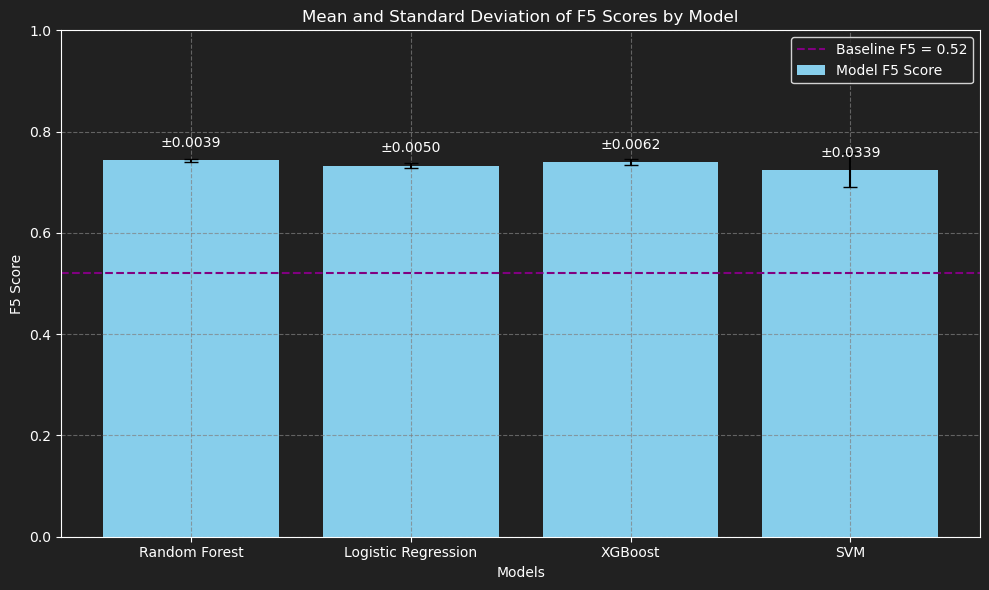

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Models and corresponding F5 scores
models = ["Random Forest", "Logistic Regression", "XGBoost", "SVM"]
average_f5_scores = [rf_average_test_f5, lr_average_test_f5, xgb_average_test_f5, svm_average_test_f5]
std_f5_scores = [rf_std_test_f5, lr_std_test_f5, xgb_std_test_f5, svm_std_test_f5]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(models, average_f5_scores, yerr=std_f5_scores, capsize=5, color='skyblue', label='Model F5 Score')

# Add baseline F5 score as a horizontal line
plt.axhline(y=baseline_f5_score, color='purple', linestyle='--', label=f"Baseline F5 = {baseline_f5_score:.2f}")

# Annotate standard deviations above each bar
for bar, std, avg in zip(bars, std_f5_scores, average_f5_scores):
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        avg + 0.02, 
        f"±{std:.4f}", 
        ha='center', 
        va='bottom', 
        color='white', 
        fontsize=10
    )

# Customizing plot
plt.gcf().set_facecolor('#212121')  # Set figure background color
plt.gca().set_facecolor('#212121')  # Set axis background color
plt.title("Mean and Standard Deviation of F5 Scores by Model", color='white')
plt.xlabel("Models", color='white')
plt.ylabel("F5 Score", color='white')
plt.ylim(0, 1.0)  # Adjust y-axis range
plt.xticks(color='white')
plt.yticks(color='white')
plt.legend(facecolor='#212121', edgecolor='white', labelcolor='white')
plt.grid(True, linestyle='--', alpha=0.7, color='gray')

plt.tight_layout()
plt.savefig('figures/model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

## **Inspect Random Forest Model** 

### **Select Best Model**

In [49]:
# Select the best model based on the highest test F5 score
best_rf_model_index = np.argmax(rf_test_scores)
best_rf_model = rf_final_models[best_rf_model_index]

print(f"Best Model Index: {best_rf_model_index}")
print(f"Test F5 Score of Best Model: {rf_test_scores[best_rf_model_index]:.4f}")    

Best Model Index: 4
Test F5 Score of Best Model: 0.7481


### **Confusion Matrix**

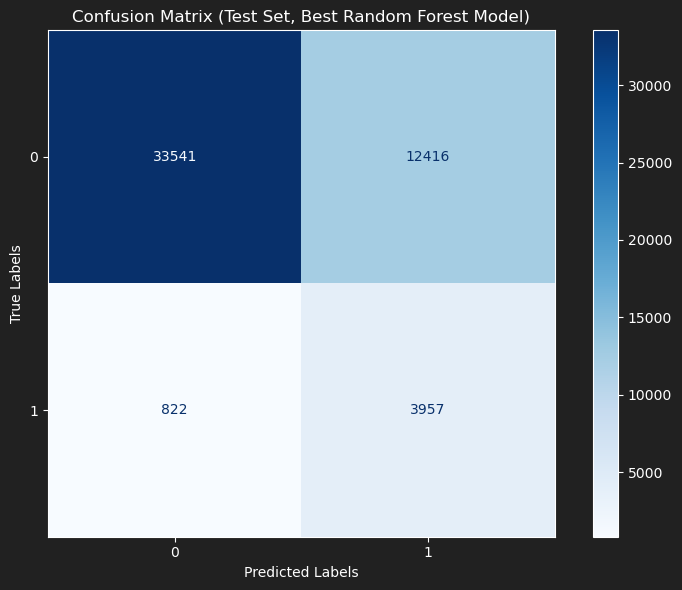

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming the best model is already determined (e.g., from rf_final_models)
best_rf_model = rf_final_models[3]  

# Use the test set directly
# Predict on the test set
rf_y_test_pred = best_rf_model.predict(rf_X_test)

# Generate confusion matrix
rf_cm_test = confusion_matrix(rf_y_test, rf_y_test_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm_test, display_labels=[0, 1])

# Customize confusion matrix display
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax)  # Plot with specific figure and axis

# Update the color bar text to white
cbar = disp.im_.colorbar  # Access the color bar
cbar.ax.yaxis.set_tick_params(color='white')  # Set tick color to white
plt.setp(plt.getp(cbar.ax, 'yticklabels'), color='white')  # Set tick labels to white

# Additional plot customization for dark theme
plt.gcf().set_facecolor('#212121')  # Dark background for the figure
plt.gca().set_facecolor('#212121')  # Dark background for the axes
plt.title("Confusion Matrix (Test Set, Best Random Forest Model)", color='white')
plt.xlabel("Predicted Labels", color='white')
plt.ylabel("True Labels", color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(False)
plt.tight_layout()
plt.savefig('figures/test_set_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



### **Permutation Importance** 

/var/folders/gf/6mk7srd56kvd7h7h_wss97200000gn/T/ipykernel_1418/1286526583.py:42: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(False, linestyle='--', alpha=0.7, color='gray')


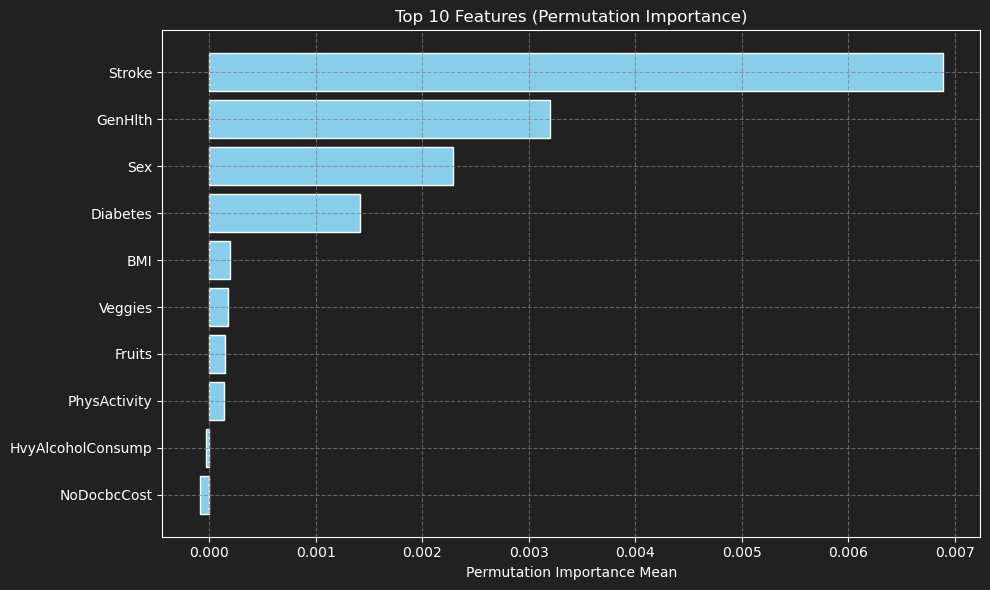

In [127]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

# Ensure the test data is preprocessed
rf_X_test_preprocessed = best_rf_model[:-1].transform(rf_X_test)  # Preprocess test data using the pipeline

# Calculate permutation importance for the best model
perm_importance = permutation_importance(
    best_rf_model[-1],  # Use the RandomForestClassifier from the pipeline
    rf_X_test_preprocessed,  # Preprocessed test data
    rf_y_test, 
    n_repeats=10, 
    random_state=0
)

# Get indices of the top 10 features sorted by importance
sorted_idx = perm_importance.importances_mean.argsort()[-10:][::-1]

# Clean feature names to remove prefixes like 'passthrough__' and 'std__'
rf_feature_names = preprocessor.get_feature_names_out()
clean_feature_names = [name.split('__')[-1] for name in rf_feature_names]

# Select the top 10 features and their importances
top_features = np.array(clean_feature_names)[sorted_idx]
top_importances = perm_importance.importances_mean[sorted_idx]

# Plot the top 10 features by permutation importance
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, align='center', color='skyblue', edgecolor='white')
plt.xlabel("Permutation Importance Mean", color='white')
plt.title("Top 10 Features (Permutation Importance)", color='white')

# Customize the plot
plt.gcf().set_facecolor('#212121')  # Dark background
plt.gca().set_facecolor('#212121')  # Axes background
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(False, linestyle='--', alpha=0.7, color='gray')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()

# Save and display the plot
plt.savefig('figures/rf_permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

### **Feature Importance by Impurity**

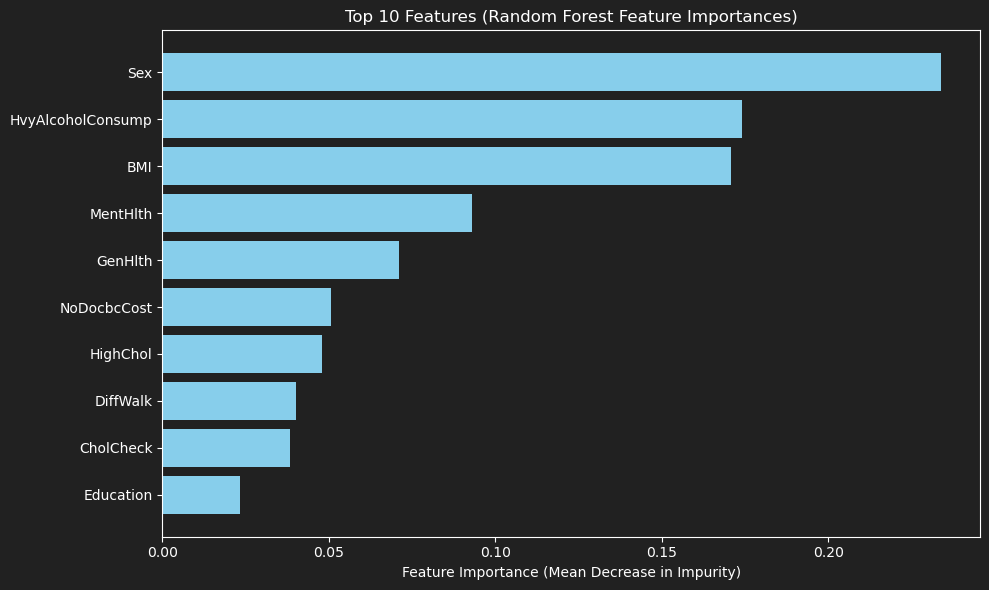

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Extract feature importances from the best random forest model
rf_feature_importances = best_rf_model.named_steps['randomforestclassifier'].feature_importances_

# Clean the feature names to remove prefixes (if needed)
clean_feature_names = [name.split('__')[-1] for name in rf_feature_names]

# Sort feature importances in descending order and select the top 10 features
sorted_indices = np.argsort(rf_feature_importances)[::-1]
top_10_indices = sorted_indices[:10]
top_10_features = np.array(clean_feature_names)[top_10_indices]
top_10_importances = rf_feature_importances[top_10_indices]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_10_features[::-1], top_10_importances[::-1], align='center', color='skyblue')
plt.xlabel("Feature Importance (Mean Decrease in Impurity)", color='white')
plt.title("Top 10 Features (Random Forest Feature Importances)", color='white')

# Customize plot appearance
plt.gcf().set_facecolor('#212121')  # Set figure background color
plt.gca().set_facecolor('#212121')  # Set axis background color
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(False)
plt.tight_layout()

plt.savefig('figures/global_importance_impurity.png', dpi=300, bbox_inches='tight')
plt.show()



### **SHAP Value Calculation**

In [53]:
import shap
shap.initjs() # required for visualizations later on

In [79]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize SHAP TreeExplainer for the best Random Forest model
explainer = shap.TreeExplainer(best_rf_model[1])
X_test_transformed = grid_search.best_estimator_[0].transform(rf_X_test)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))


(1000, 21, 2)


In [132]:
# Clean feature names to remove everything before '__'
clean_feature_names = [name.split('__')[-1] for name in rf_feature_names]

# Generate SHAP force plot for class 0
index = 5  # Example index
print("Expected Value (Class 0):", explainer.expected_value[0])

shap.force_plot(
    explainer.expected_value[0],  # Expected value for class 0
    shap_values[index, :, 0],  # SHAP values for the specified index and class 0
    features=X_test_transformed[index, :],  # Features for the specified index
    feature_names=clean_feature_names  # Use cleaned feature names
)

shap.save_html('figures/class_0_shap.html', force_plot)  # Save as interactive HTML


Expected Value (Class 0): 0.500159148034137


In [131]:
# Clean feature names to remove everything before '__'
clean_feature_names = [name.split('__')[-1] for name in rf_feature_names]

# Generate SHAP force plot
index = 19  # Example index
print("Expected Value (Class 1):", explainer.expected_value[1])

# Create the SHAP force plot
force_plot = shap.force_plot(
    explainer.expected_value[0], 
    shap_values[index, :, 0], 
    features=X_test_transformed[index, :], 
    feature_names=clean_feature_names
)

# Save the force plot as an image
shap.save_html('figures/class_1_shap.html', force_plot)  # Save as interactive HTML

Expected Value (Class 1): 0.4998408519658628


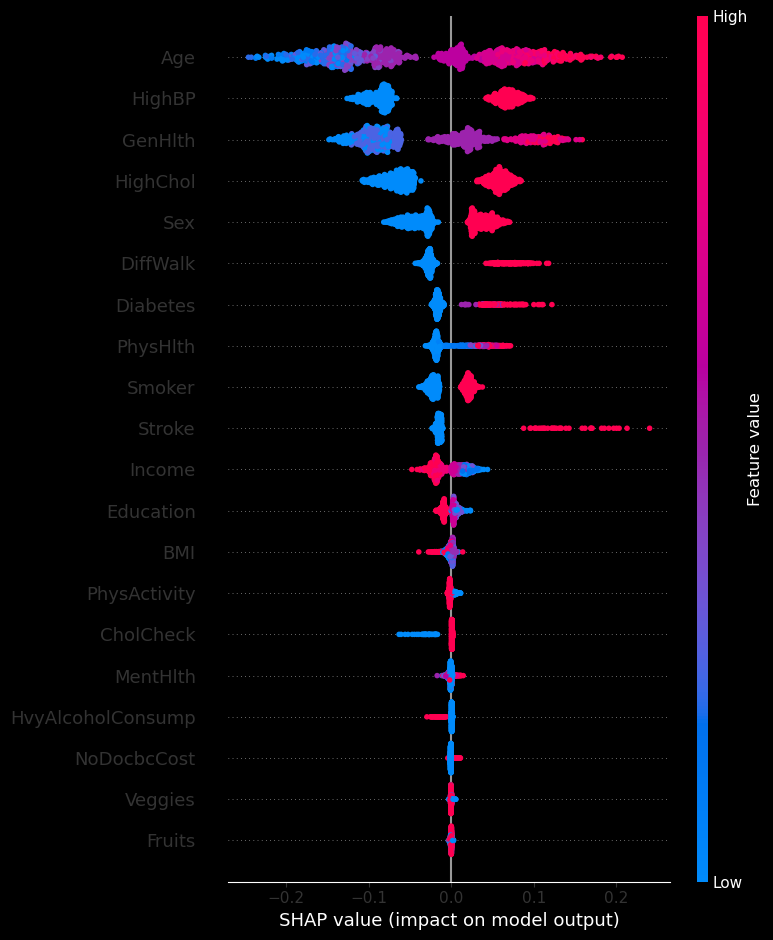

In [137]:
import shap
import matplotlib.pyplot as plt

# Clean feature names to remove everything before '__'
clean_feature_names = [name.split('__')[-1] for name in rf_feature_names]

# Create a SHAP summary plot and explicitly define the figure
plt.style.use('dark_background')  # Use dark background style
fig = plt.figure(figsize=(10, 8))  # Define figure size for SHAP plot
shap.summary_plot(
    shap_values[:, :, 1],  # SHAP values for class 1
    X_test_transformed[:1000],  # Corresponding transformed test data
    feature_names=clean_feature_names,  # Use cleaned feature names
    show=False  # Prevent the plot from being displayed immediately
)

# Save the figure
fig.savefig('figures/global_shap.png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()

### **Class Distribution**

Class Distribution:
Class 0.0: 229787 (90.58%)
Class 1.0: 23893 (9.42%)


/var/folders/gf/6mk7srd56kvd7h7h_wss97200000gn/T/ipykernel_1418/1396300211.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


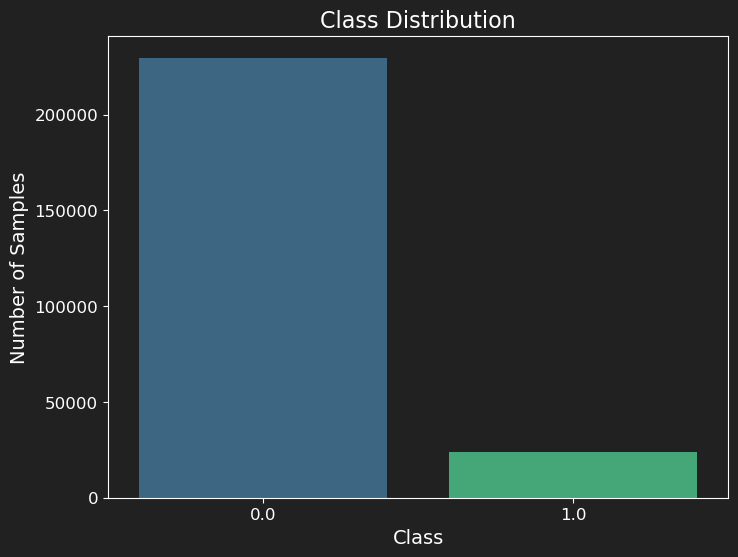

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of instances for each class
class_counts = y.value_counts()

# Print class distribution
print("Class Distribution:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} ({count / len(y) * 100:.2f}%)")

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution", fontsize=16, color='white')
plt.xlabel("Class", fontsize=14, color='white')
plt.ylabel("Number of Samples", fontsize=14, color='white')
plt.xticks(color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)

# Dark background
plt.gcf().set_facecolor('#212121')  # Set figure background color
plt.gca().set_facecolor('#212121')  # Set axis background color

plt.savefig('figures/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

